Assignment
===========
The dataset was used in the 1983 American Statistical Association Exposition. The data concerns city-cycle fuel consumption in miles per gallon, to be predicted in terms of 2 multivalued discrete and 4 continuous variables. 
Dataset: cars-dataset.csv

Attribute Information:
-------------------------------
Car Name – Name of the car
Cyl – No of cylinders in the car – Multivalued discrete
Disp – Displacement – continuous
Hp – Horsepower – continuous
Wt – Weight – continuous
Acc – Accleration – continuous
Yr – Model of the car – Multivalued discrete

Steps to follow:
---------------------------
EDA & Pre-processing (Make sure to remove all non-numeric entries from numeric columns) – 2.5 points
Use pair plot or scatter matrix to visualize how the different variables are related (Hint: The amount of Gaussian curves in the plot should give a visual identification of different clusters existing in the dataset) – 5 points
Use K Means or Hierarchical clustering to find out the optimal no of clusters in the data. Identify and separate the clusters (15 points)
Use linear regression model on different clusters separately and print the coefficients of the models individually (7.5 points)
Please note: Since going forward, you will be pushing all your assessment files to the same repository for the remainder of the program, so it is important that you follow some name structure to identify your assessment submission properly.

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm

from sklearn.preprocessing import LabelEncoder

1. Data Exploration
-------------------------
EDA & Pre-processing (Make sure to remove all non-numeric entries from numeric columns) – 2.5 points

In [19]:
car_df=pd.read_csv('cars-dataset.csv')
car_df.head()

,car name,cyl,disp,hp,wt,acc,yr,mpg
0,chevrolet chevelle malibu,8,307.0,130,3504,12.0,70,18.0
1,buick skylark 320,8,350.0,165,3693,11.5,70,15.0
2,plymouth satellite,8,318.0,150,3436,11.0,70,18.0
3,amc rebel sst,8,304.0,150,3433,12.0,70,16.0
4,ford torino,8,302.0,140,3449,10.5,70,17.0


In [20]:
car_df.rename(columns={'car name':'car_name'},inplace=True)

In [21]:
car_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 8 columns):
car_name    398 non-null object
cyl         398 non-null int64
disp        398 non-null float64
hp          398 non-null object
wt          398 non-null int64
acc         398 non-null float64
yr          398 non-null int64
mpg         398 non-null float64
dtypes: float64(3), int64(3), object(2)
memory usage: 25.0+ KB


In [22]:
car_df.shape

(398, 8)

In [23]:
# Convert column 'hp' to int64
try:
    car_df.hp.astype(np.int64)
except Exception as ex:
    print(ex)

invalid literal for int() with base 10: '?'


In [24]:
car_df[car_df.hp == "?"]

,car_name,cyl,disp,hp,wt,acc,yr,mpg
32,ford pinto,4,98.0,?,2046,19.0,71,25.0
126,ford maverick,6,200.0,?,2875,17.0,74,21.0
330,renault lecar deluxe,4,85.0,?,1835,17.3,80,40.9
336,ford mustang cobra,4,140.0,?,2905,14.3,80,23.6
354,renault 18i,4,100.0,?,2320,15.8,81,34.5
374,amc concord dl,4,151.0,?,3035,20.5,82,23.0


In [25]:
# Replace ? with median 
# first replace ? with NaN
car_df.hp.replace('?', np.nan, inplace=True)
car_df[car_df.hp == '?']

,car_name,cyl,disp,hp,wt,acc,yr,mpg


In [26]:
car_df.hp.fillna(car_df.hp.median(), inplace=True)
car_df.hp = car_df.hp.astype(np.int64)

In [27]:
car_df.describe().T

,count,mean,std,min,25%,50%,75%,max
cyl,398.0,5.454774,1.701004,3.0,4.000,4.0,8.000,8.0
disp,398.0,193.425879,104.269838,68.0,104.250,148.5,262.000,455.0
hp,398.0,104.296482,38.224809,46.0,76.000,93.0,125.000,230.0
wt,398.0,2970.424623,846.841774,1613.0,2223.750,2803.5,3608.000,5140.0
acc,398.0,15.568090,2.757689,8.0,13.825,15.5,17.175,24.8
yr,398.0,76.010050,3.697627,70.0,73.000,76.0,79.000,82.0
mpg,398.0,23.514573,7.815984,9.0,17.500,23.0,29.000,46.6


In [28]:
#checking Nulls
car_df.isnull().sum()

car_name    0
cyl         0
disp        0
hp          0
wt          0
acc         0
yr          0
mpg         0
dtype: int64

In [29]:
#Unique Cars
len(car_df.car_name.unique())

305

In [30]:
#Unique ye
len(car_df.yr.unique())

13

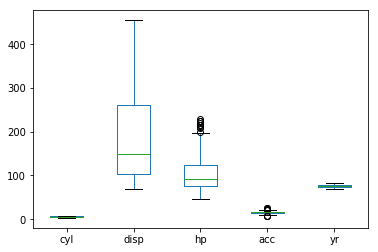

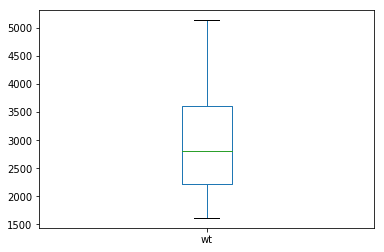

In [31]:
#outliers
car_df[['cyl','disp','hp','acc','yr']].plot(kind='box')
car_df[['wt']].plot(kind='box')

plt.savefig('boxplot_outliers.png')

In [34]:
numeric_cols = list(car_df.select_dtypes(['float64','int64']).columns)
numeric_cols

['cyl', 'disp', 'hp', 'wt', 'acc', 'yr', 'mpg']

In [36]:
X = car_df[numeric_cols]

In [37]:
## Finding ouliers
from itertools import chain
outlier_rec = []
# For each predictors find outliers using mathematical function.
def find_outlier(df_in, col_name, verbose=False):
    q25 = df_in[col_name].quantile(0.25)
    q75 = df_in[col_name].quantile(0.75)
    iqr = q75-q25 #Interquartile range
    lower, upper  = q25-1.5*iqr, q75+1.5*iqr
    outliers_df = df_in[(df_in[col_name] < lower) | (df_in[col_name] > upper)]
    outliers_removed_df = df_in[(df_in[col_name] >= lower) & (df_in[col_name] <= upper)]
    
    if(verbose):
        print('# Number of outliers / non-outliers for column \'{}\': {} /{}'.format(
            col_name, outliers_df.shape[0], outliers_removed_df.shape[0]))
    return outliers_df.index.tolist();

for feature in numeric_cols:
    outlier_rec.append(find_outlier(car_df, feature, True))
    
outlier_rec = list(chain.from_iterable(outlier_rec))
outlier_rec = list(set(outlier_rec)) 
outlier_rec.sort()
print('# Total outliers in the dataset: {}'.format(len(outlier_rec)))
print(outlier_rec)

# Number of outliers / non-outliers for column 'cyl': 0 /398
# Number of outliers / non-outliers for column 'disp': 0 /398
# Number of outliers / non-outliers for column 'hp': 11 /387
# Number of outliers / non-outliers for column 'wt': 0 /398
# Number of outliers / non-outliers for column 'acc': 9 /389
# Number of outliers / non-outliers for column 'yr': 0 /398
# Number of outliers / non-outliers for column 'mpg': 1 /397
# Total outliers in the dataset: 20
[6, 7, 8, 9, 11, 13, 25, 26, 27, 59, 67, 94, 95, 116, 195, 299, 300, 322, 326, 394]


In [38]:
car_df.drop(outlier_rec, inplace=True)
car_df.shape

(378, 8)

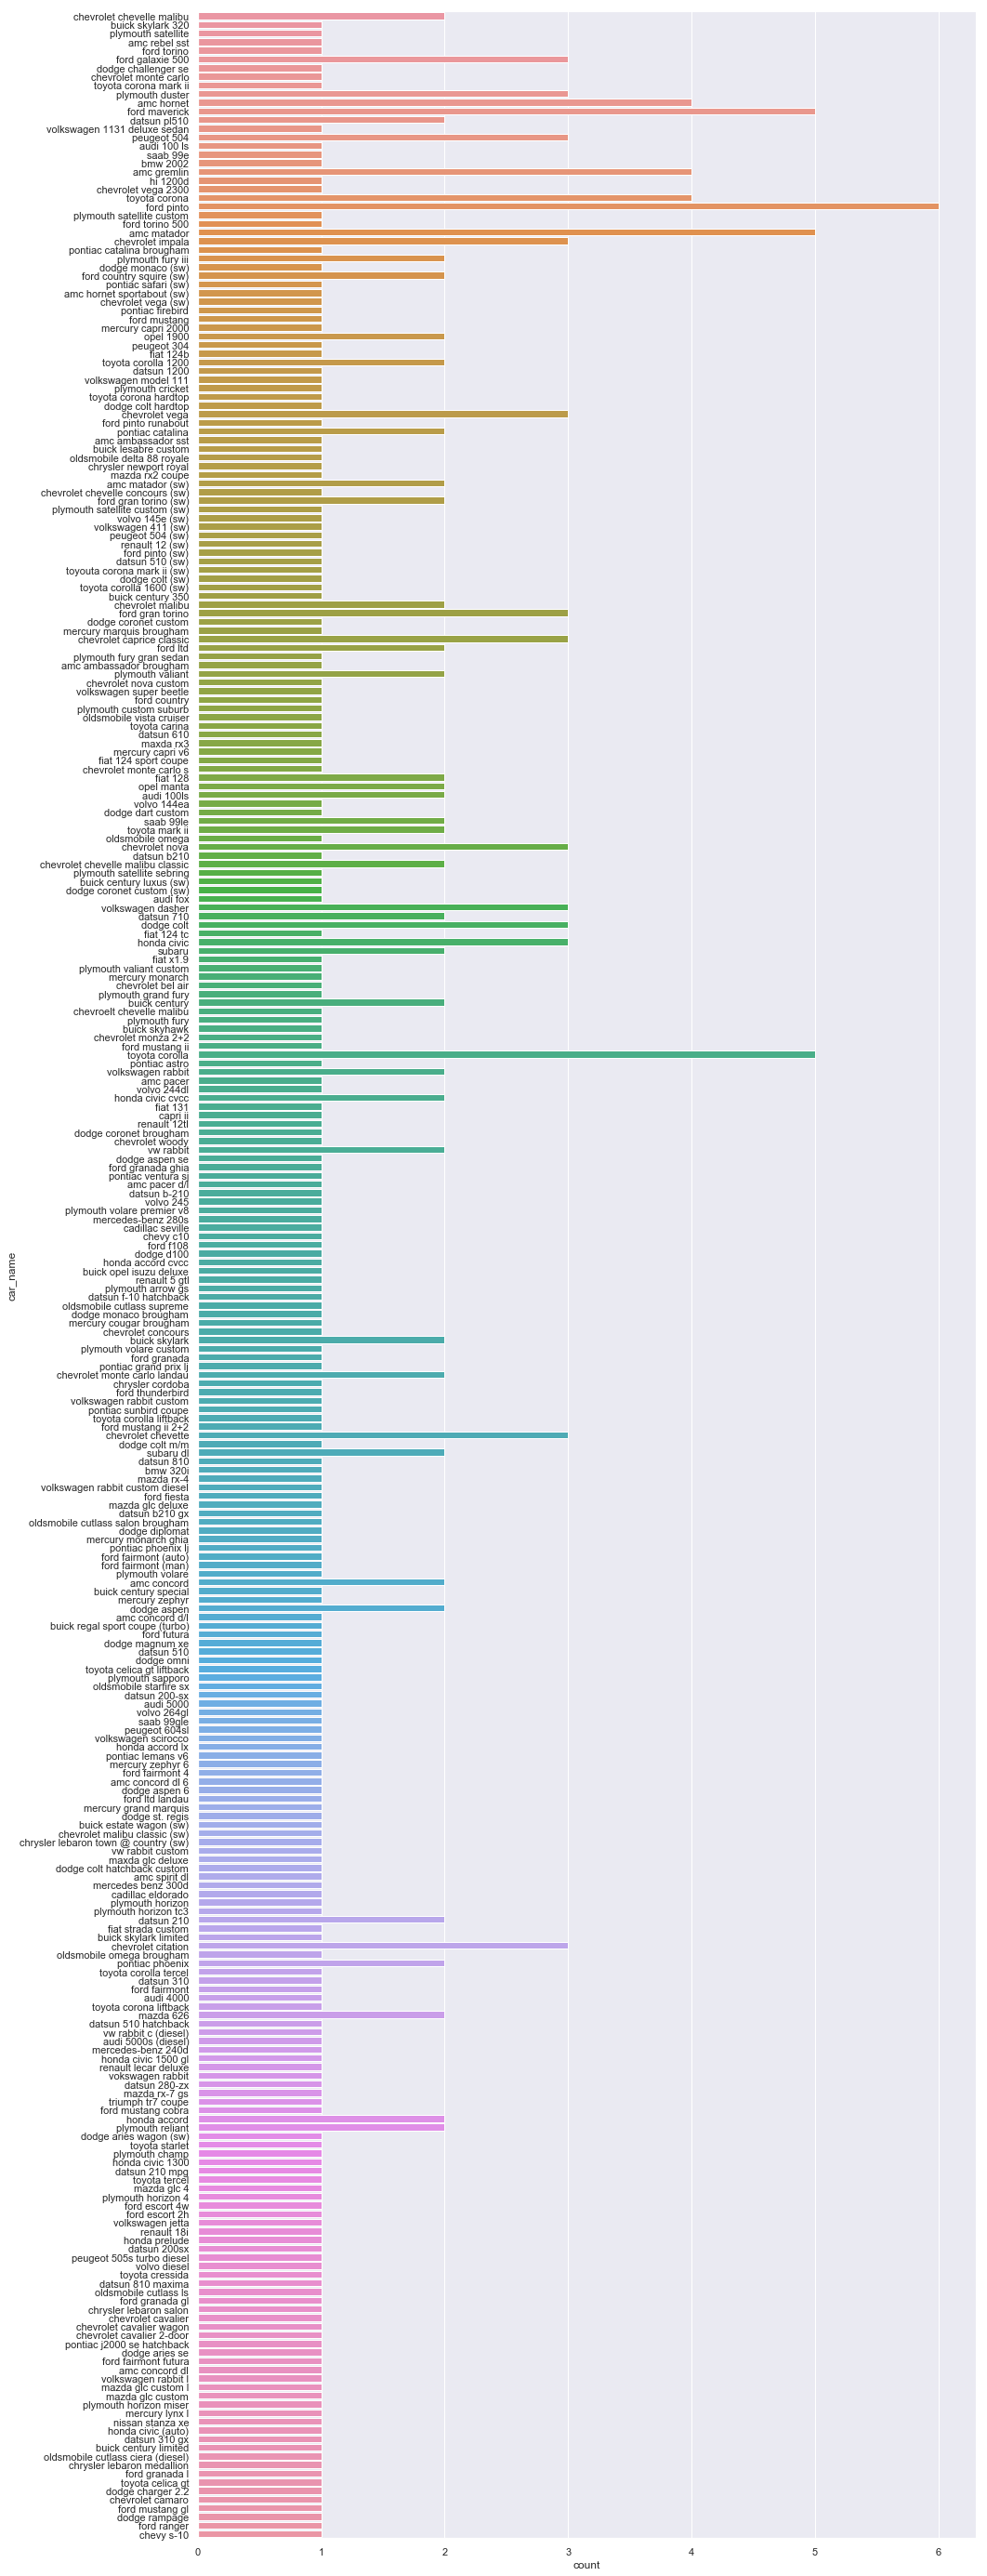

In [39]:
sns.set(rc={'figure.figsize':(15,50)})
sns.countplot(y='car_name', data=car_df)

In [40]:
# time range in years
car_df.yr.min()

70

In [41]:
car_df.yr.max()

82

2. VISUALIZATION to find VARIABLE RELATIONS 
Use pair plot or scatter matrix to visualize how the different variables are related (Hint: The amount of Gaussian curves in the plot should give a visual identification of different clusters existing in the dataset) – 5 points

In [42]:
#rename column -  car name
car_df.rename(columns={"car name":"car_name"},inplace=True)
car_df.head()

,car_name,cyl,disp,hp,wt,acc,yr,mpg
0,chevrolet chevelle malibu,8,307.0,130,3504,12.0,70,18.0
1,buick skylark 320,8,350.0,165,3693,11.5,70,15.0
2,plymouth satellite,8,318.0,150,3436,11.0,70,18.0
3,amc rebel sst,8,304.0,150,3433,12.0,70,16.0
4,ford torino,8,302.0,140,3449,10.5,70,17.0


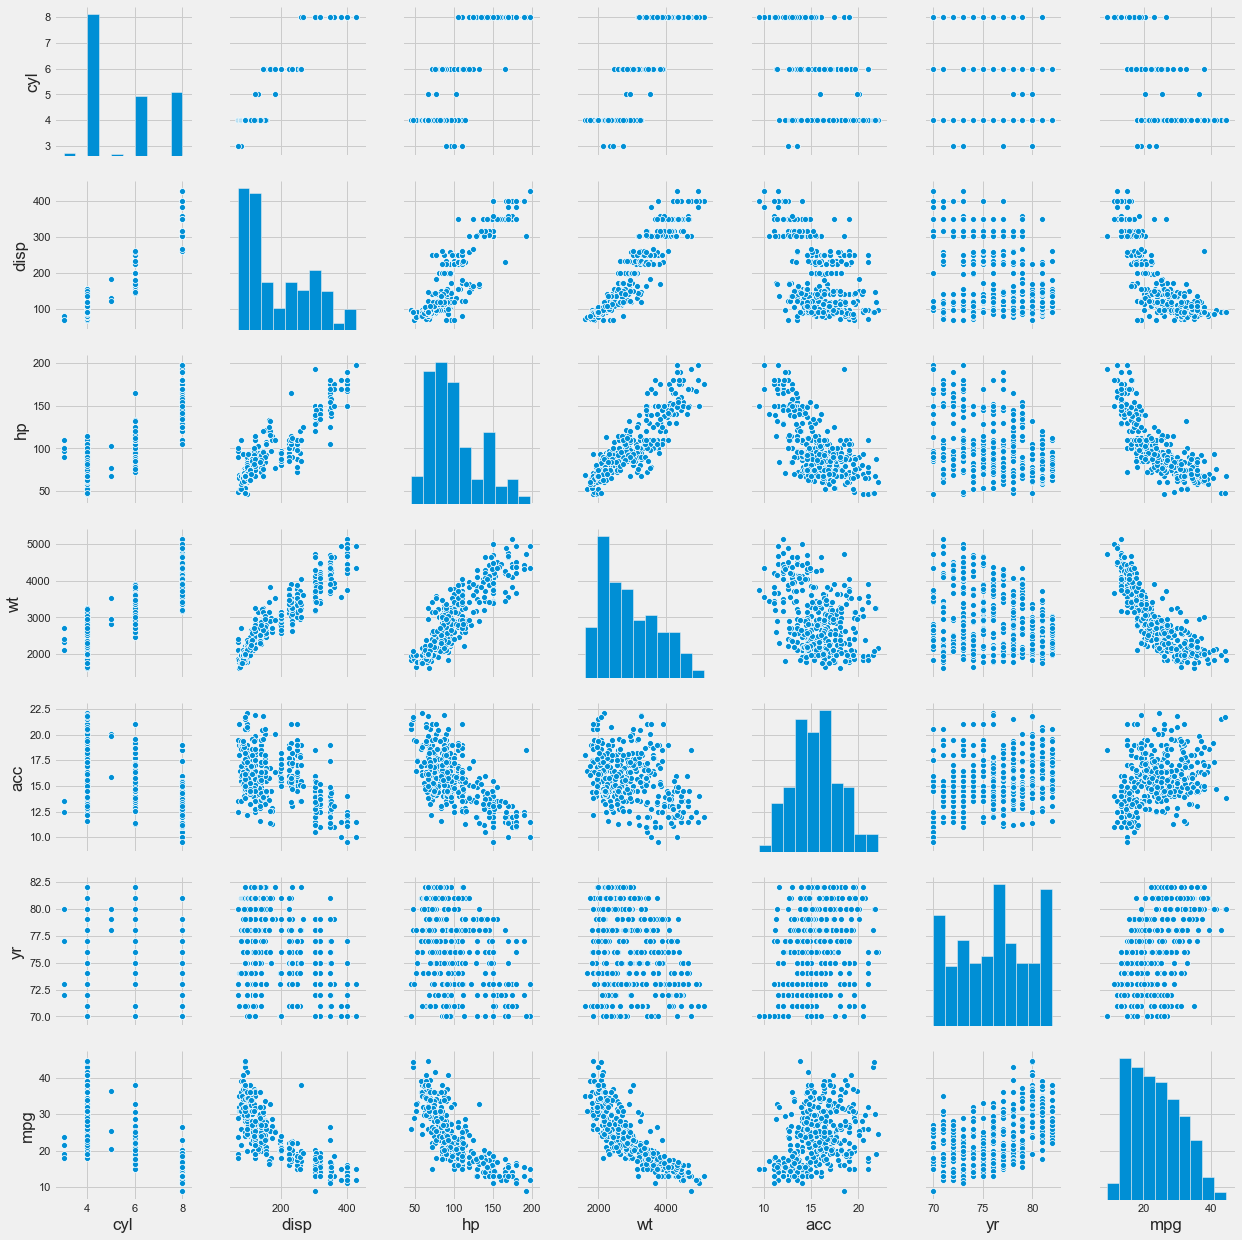

In [74]:
sns.pairplot(car_df, hue=None, palette='Blues')

3. Use K Means or Hierarchical clustering to find out the optimal no of clusters in the data. Identify and separate the clusters (15 points)

In [44]:
features = car_df.drop('car_name', axis=1)
target = car_df['mpg']
car_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 378 entries, 0 to 397
Data columns (total 8 columns):
car_name    378 non-null object
cyl         378 non-null int64
disp        378 non-null float64
hp          378 non-null int64
wt          378 non-null int64
acc         378 non-null float64
yr          378 non-null int64
mpg         378 non-null float64
dtypes: float64(3), int64(4), object(1)
memory usage: 36.6+ KB


In [45]:
car_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 378 entries, 0 to 397
Data columns (total 8 columns):
car_name    378 non-null object
cyl         378 non-null int64
disp        378 non-null float64
hp          378 non-null int64
wt          378 non-null int64
acc         378 non-null float64
yr          378 non-null int64
mpg         378 non-null float64
dtypes: float64(3), int64(4), object(1)
memory usage: 36.6+ KB


In [46]:
numeric_cols = list(car_df.select_dtypes(['float64','int64']).columns)
numeric_cols

['cyl', 'disp', 'hp', 'wt', 'acc', 'yr', 'mpg']

In [47]:
X = car_df[numeric_cols]

In [48]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
ar_df_std =  sc.fit_transform(X)
car_df_std.shape

C:\Anaconda\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Anaconda\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


NameError: name 'car_df_std' is not defined

In [49]:
from scipy.cluster.hierarchy import dendrogram, linkage

# generate the linkage matrix
Z = linkage(X, 'ward', metric='euclidean')

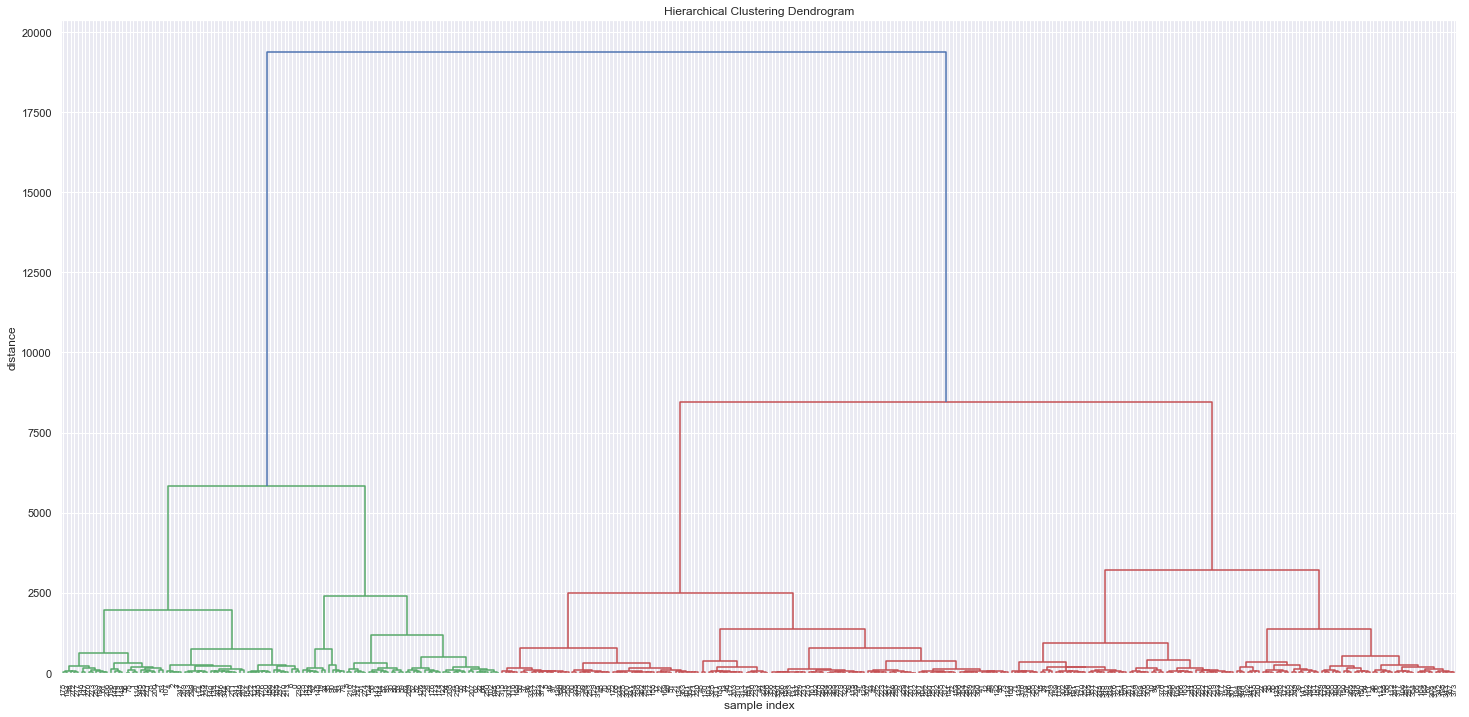

In [50]:
# Plot the dendrogram 
plt.figure(figsize=(25, 12))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(
    Z,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
)
plt.show()

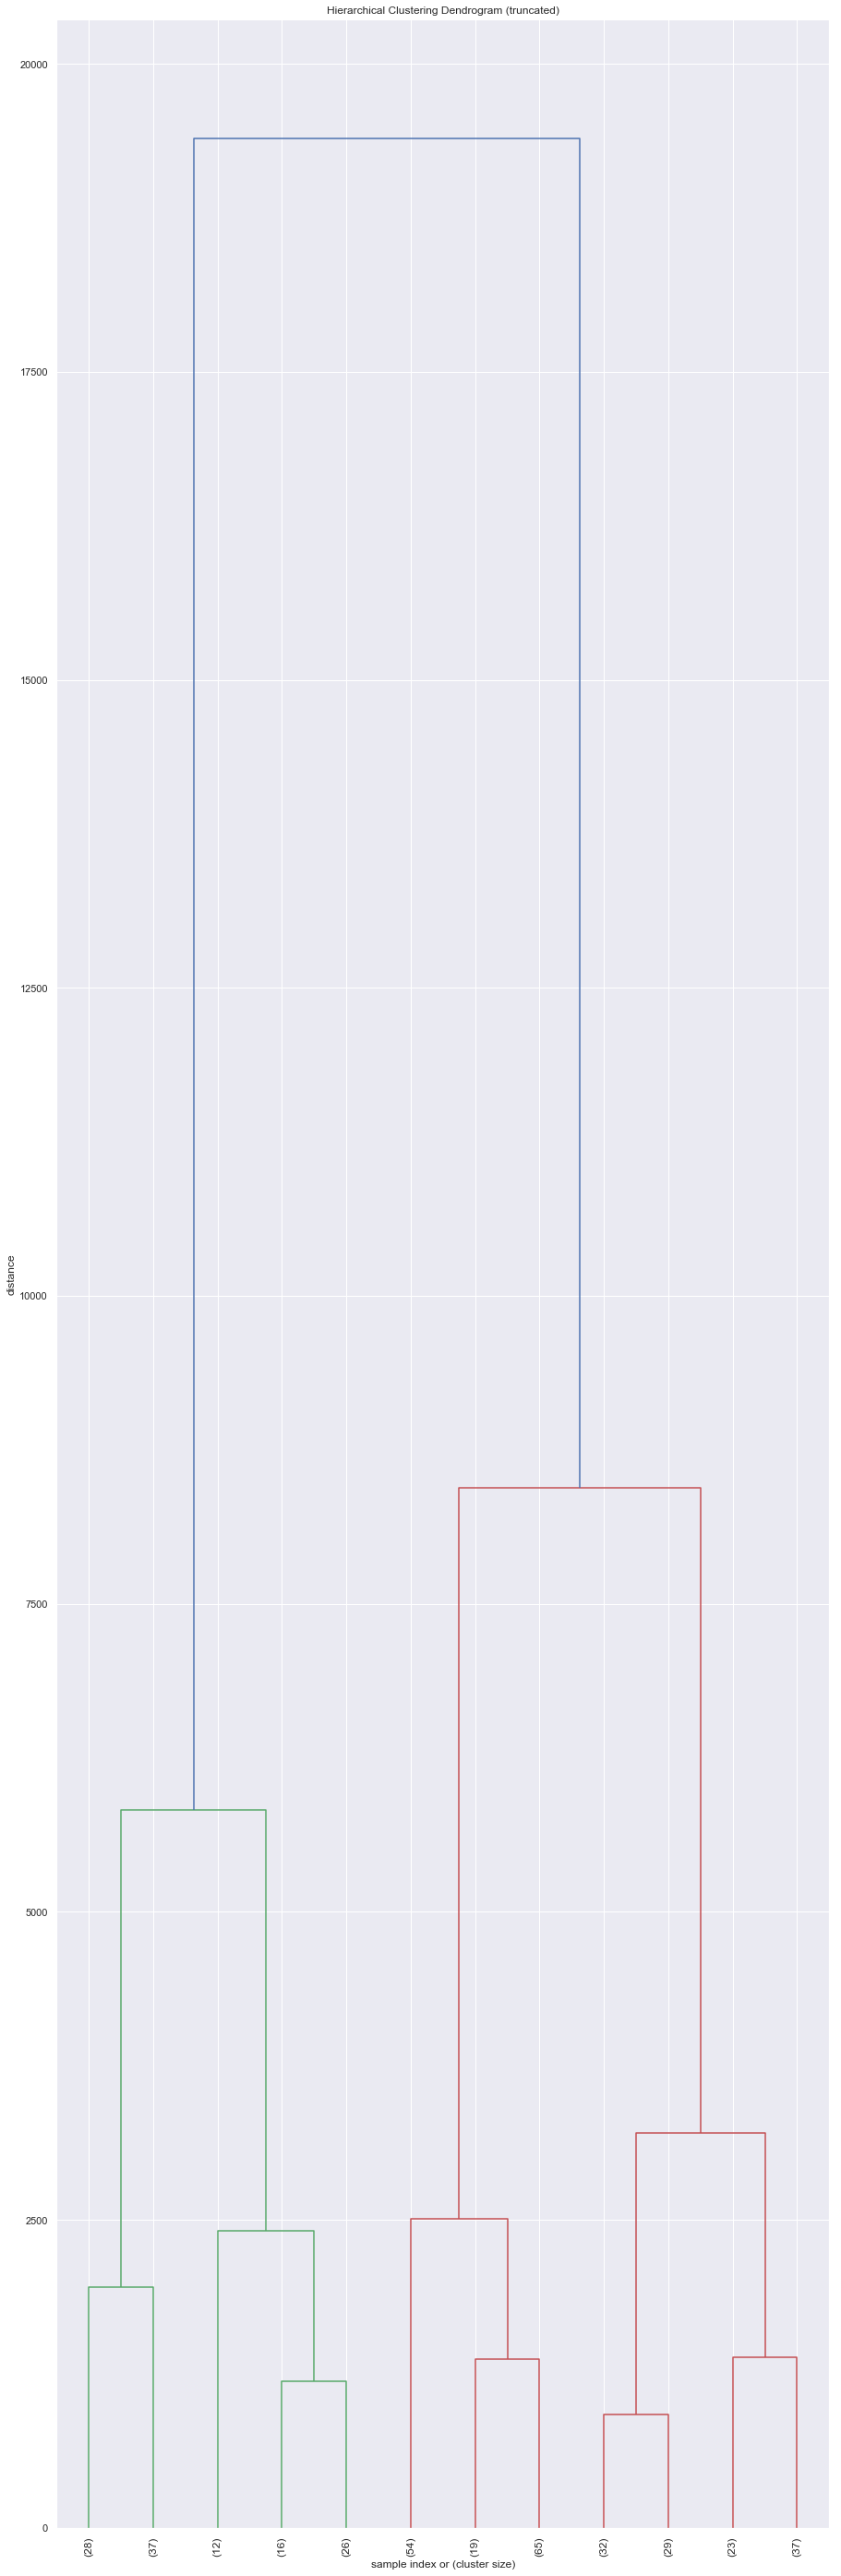

In [51]:
# Recreate the dendrogram for last 12 merged clusters
plt.title('Hierarchical Clustering Dendrogram (truncated)')
plt.xlabel('sample index or (cluster size)')
plt.ylabel('distance')
dendrogram(
    Z,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=12,  # show only the last p merged clusters
    leaf_rotation=90.,
    leaf_font_size=12.,
)
plt.show()

From the truncated dendrogram, find out the optimal distance between clusters which one want to use an input for clustering data
Selecting a Distance Cut-Off aka Determining the Number of Clusters

cut-off is 7500, as the jump is pretty obvious:

In [52]:
## Using this distance measure and fcluster function to cluster the data into X different groups
from scipy.cluster.hierarchy import fcluster
max_d = 7500
clusters = fcluster(Z, max_d, criterion='distance')
print(f'Number of clusters: {len(set(clusters))}')
print(f'Clusters values: {set(clusters)}')

Number of clusters: 3
Clusters values: {1, 2, 3}


In [53]:
car_df1 = pd.DataFrame(X, columns=numeric_cols)
car_df1['cluster'] = pd.Series(clusters, index=car_df.index)
car_df1.sample(5)

,cyl,disp,hp,wt,acc,yr,mpg,cluster
241,6,146.0,97,2815,14.5,77,22.0,3
379,4,98.0,70,2125,17.3,82,36.0,2
171,4,134.0,96,2702,13.5,75,24.0,3
70,8,400.0,190,4422,12.5,72,13.0,1
159,8,351.0,148,4657,13.5,75,14.0,1


In [54]:
car_df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 378 entries, 0 to 397
Data columns (total 8 columns):
cyl        378 non-null int64
disp       378 non-null float64
hp         378 non-null int64
wt         378 non-null int64
acc        378 non-null float64
yr         378 non-null int64
mpg        378 non-null float64
cluster    378 non-null int32
dtypes: float64(3), int32(1), int64(4)
memory usage: 35.1 KB


4. Use linear regression model on different clusters separately and print the coefficients of the models individually (7.5 points) 

In [55]:
c1 =car_df1[car_df1.cluster==1][['cyl', 'disp', 'hp', 'wt', 'acc', 'yr','mpg']]
c2 = car_df1[car_df1.cluster==2][['cyl', 'disp', 'hp', 'wt', 'acc', 'yr','mpg']]
c3 = car_df1[car_df1.cluster==3][['cyl', 'disp', 'hp', 'wt', 'acc', 'yr','mpg']]

c1.shape, c2.shape, c3.shape

((119, 7), (138, 7), (121, 7))

In [65]:
from sklearn import datasets, linear_model, metrics
from sklearn.model_selection import train_test_split

def model_using_LR(X, y):
    # splitting X and y into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,
                                                        random_state=1)
    # create linear regression object
    reg = linear_model.LinearRegression()

    # train the model using the training sets
    reg.fit(X_train, y_train)

    # regression coefficients
    print('Coefficients: \n', reg.coef_)

    # variance score: 1 means perfect prediction
    print('Variance score: {}'.format(reg.score(X_test, y_test)))

    # plot for residual error

    ## setting plot style
    plt.style.use('fivethirtyeight')

    ## plotting residual errors in training data
    plt.scatter(reg.predict(X_train), reg.predict(X_train) - y_train,
                color = "brown", s = 10, label = 'Train data')

    ## plotting residual errors in test data
    plt.scatter(reg.predict(X_test), reg.predict(X_test) - y_test,
                color = "blue", s = 10, label = 'Test data')

    ## plotting line for zero residual error
    plt.hlines(y = 0, xmin = 0, xmax = 50, linewidth = 2)

    ## plotting legend
    plt.legend(loc = 'upper right')

    ## plot title
    plt.title("Residual errors")

Coefficients: 
 [-0.02027215  0.00342806 -0.02231084 -0.00284938 -0.12536448  0.37497408]
Variance score: 0.5458953180948785


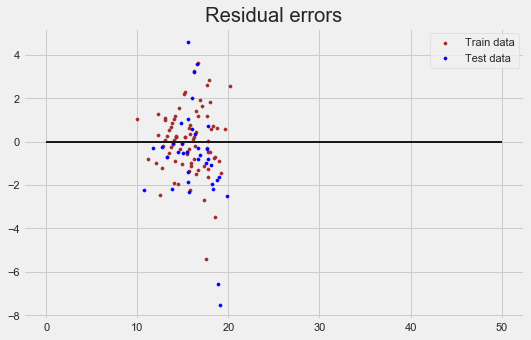

In [68]:
## Cluster 1 data
plt.figure(figsize=(8, 5))
X = c1[['cyl', 'disp', 'hp', 'wt', 'acc', 'yr']]
y = c1['mpg']
model_using_LR(X, y)

Coefficients: 
 [ 8.57812400e+00 -6.19399619e-02 -6.69498318e-03 -7.55691704e-03
 -5.25967434e-02  9.38621450e-01]
Variance score: 0.7253900310427481


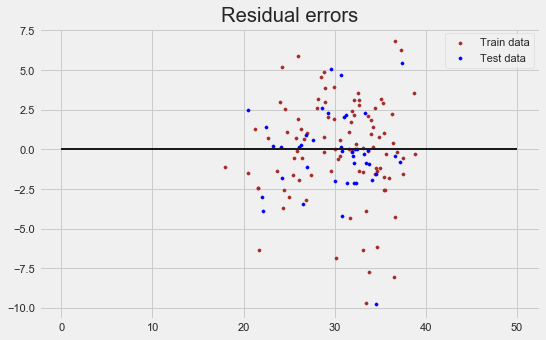

In [69]:
## Cluster 2 data
plt.figure(figsize=(8, 5))
X = c2[['cyl', 'disp', 'hp', 'wt', 'acc', 'yr']]
y = c2['mpg']

model_using_LR(X, y)

Coefficients: 
 [ 0.97016412 -0.03549573 -0.13771216 -0.00273431 -0.4480513   0.70918639]
Variance score: 0.5319832654120286


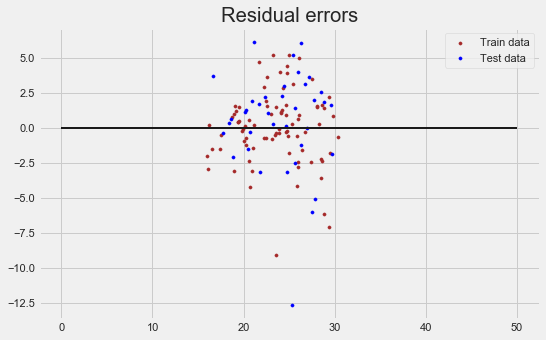

In [70]:
## Cluster 3 data
plt.figure(figsize=(8, 5))
X = c3[['cyl', 'disp', 'hp', 'wt', 'acc', 'yr']]
y = c3['mpg']

model_using_LR(X, y)

Coefficients: 
 [-0.1948641   0.00548844 -0.03510954 -0.0059502  -0.14361703  0.72461784]
Variance score: 0.8231602641735465


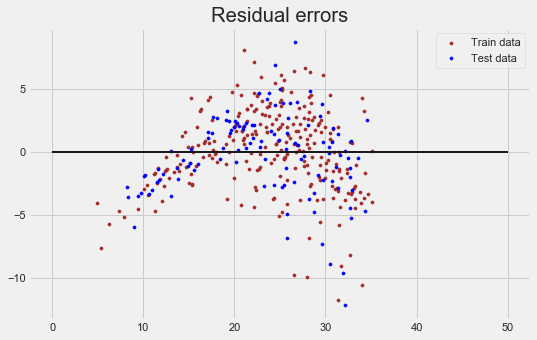

In [71]:
## consolidated data
plt.figure(figsize=(8, 5))
X = car_df[['cyl', 'disp', 'hp', 'wt', 'acc', 'yr']]
y = car_df['mpg']

model_using_LR(X, y)